In [1]:
from atomai import utils
from atomai import stat as atomstat
import atomai as aoi
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import gdown
import h5py
import wget
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.patches as patches
from PIL import Image

In [2]:
#list files
filedir = '../../data'
[f for f in os.listdir(filedir)]

['Sm_7_2_HAADF.h5',
 'Sm_0_1_UCParameterization.h5',
 'Sm_13_0_HAADF.h5',
 'Sm_10_1_UCParameterization.h5',
 'Sm_20_0_UCParameterization.h5',
 'Sm_7_2_UCParameterization.h5',
 'Sm_10_1_HAADF.h5',
 'Sm_13_0_UCParameterization.h5',
 'Sm_20_0_HAADF.h5',
 'Sm_0_1_HAADF.h5']

In [3]:
#image files
composition_tags = [0,7,10,13,20]    #Sm composition %


img_filename = ['Sm_0_1_HAADF.h5',
                'Sm_7_2_HAADF.h5',
                'Sm_10_1_HAADF.h5',
                'Sm_13_0_HAADF.h5',
                'Sm_20_0_HAADF.h5',]

imnum = len(img_filename)

#parametrization files

UCparam_filename = ['Sm_0_1_UCParameterization.h5',
                    'Sm_7_2_UCParameterization.h5',
                    'Sm_10_1_UCParameterization.h5',
                    'Sm_13_0_UCParameterization.h5',
                    'Sm_20_0_UCParameterization.h5',]

#load parameter files
UCparam = []
for x in UCparam_filename:
  print('loading parameterization file: ', os.path.join(filedir, x))
  temp = h5py.File(os.path.join(filedir, x), 'r')
  UCparam.append(temp)

#load images
imgdata = []
for x in img_filename:
  print('loading image file: ', os.path.join(filedir, x))
  temp = h5py.File(os.path.join(filedir, x), 'r')['MainImage']
  imgdata.append(temp)

print('UC parameterization:', [k for k in UCparam[0].keys()])

loading parameterization file:  ../../data/Sm_0_1_UCParameterization.h5
loading parameterization file:  ../../data/Sm_7_2_UCParameterization.h5
loading parameterization file:  ../../data/Sm_10_1_UCParameterization.h5
loading parameterization file:  ../../data/Sm_13_0_UCParameterization.h5
loading parameterization file:  ../../data/Sm_20_0_UCParameterization.h5
loading image file:  ../../data/Sm_0_1_HAADF.h5
loading image file:  ../../data/Sm_7_2_HAADF.h5
loading image file:  ../../data/Sm_10_1_HAADF.h5
loading image file:  ../../data/Sm_13_0_HAADF.h5
loading image file:  ../../data/Sm_20_0_HAADF.h5
UC parameterization: ['I1', 'I2', 'I3', 'I4', 'I5', 'NCOM', 'PCOM', 'Pxy', 'Vol', 'a', 'ab', 'abdelta', 'alpha', 'atmindex', 'b', 'index', 'meanuca', 'meanucb', 'nbrUC', 'xy_COM', 'xy_atms']


In [4]:
#function maps x,y grid positions into a matrix data format
def map2grid(inab, inVal):

  default_val = np.nan
  abrng = [int(np.min(inab[:,0])), int(np.max(inab[:,0])), int(np.min(inab[:,1])), int(np.max(inab[:,1]))]
  abind = inab
  abind[:,0] -= abrng[0]
  abind[:,1] -= abrng[2]
  Valgrid = np.empty((abrng[1]-abrng[0]+1,abrng[3]-abrng[2]+1))
  Valgrid[:] = default_val
  Valgrid[abind[:,0].astype(int),abind[:,1].astype(int)]=inVal[:]
  return Valgrid, abrng

In addition to the raw STEM data, the parametrization files yield the information on each unit cell within the data that we can use as a physics-based comparison to ML analyses. For example, I1-5 are intensity of atomic columns, Vol is unit cell volume, Pxy are polarization components, and so on.


In [5]:
def plot_polarization_vectors(k):
    X = k['ab_x'].ravel()
    Y = k['ab_y'].ravel()
    U = k['ab_Px'].ravel()
    V = k['ab_Py'].ravel()
    Pmag = np.sqrt(U**2 + V**2)
    Pdir = np.arctan2(V, U)
    norm = Normalize(vmin=-np.pi, vmax=np.pi)
    cmap = cm.hsv  
    cP = cmap(norm(Pdir))
    return Y, X, U, V, cP

In [6]:
SBFOdata = []     #this will be the output list of dictionaries for each dataset

for i in np.arange(imnum):
  temp_dict = {'Index': i}
  temp_dict['Composition'] = composition_tags[i]
  temp_dict['Image'] = imgdata[i]
  temp_dict['Filename'] = img_filename[i]

  for k in UCparam[i].keys():       #add labels for UC parameterization
    temp_dict[k] = UCparam[i][k][()]

  #select values mapped to ab grid
  temp_dict['ab_a'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['ab'][()].T[:,0])[0]       #a array
  temp_dict['ab_b'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['ab'][()].T[:,1])[0]       #b array
  temp_dict['ab_x'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['xy_COM'][()].T[:,0])[0]   #x array
  temp_dict['ab_y'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['xy_COM'][()].T[:,1])[0]   #y array
  temp_dict['ab_Px'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Pxy'][0])[0]             #Px array
  temp_dict['ab_Py'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Pxy'][1])[0]        #Py array
  temp_dict['Vol'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Vol'])[0]     #Vol array

  SBFOdata.append(temp_dict)

In [7]:
def custom_subimages(imgdata, step_size, window_size):
    # Generate coordinates based on step size
    height, width = imgdata.shape[:2]
    x_coords = np.arange(0, height - window_size[0] + 1, step_size)
    y_coords = np.arange(0, width - window_size[1] + 1, step_size)
    coordinates = [(x, y) for x in x_coords for y in y_coords]

    # Extract subimages of the specified window size
    half_height = window_size[0] // 2
    half_width = window_size[1] // 2
    subimages_target = []
    coms_target = []
    removed_due_to_size = 0
    removed_due_to_nans = 0

    for coord in coordinates:
        cx, cy = coord
        top = max(cx - half_height, 0)
        bottom = min(cx + half_height, height)
        left = max(cy - half_width, 0)
        right = min(cy + half_width, width)

        subimage = imgdata[top:bottom, left:right]

        if subimage.shape != tuple(window_size):
            removed_due_to_size += 1
        elif np.isnan(subimage).any():
            removed_due_to_nans += 1
        else:
            subimages_target.append(subimage)
            coms_target.append(coord)

    print("Number of subimages removed due to size mismatch:", removed_due_to_size)
    print("Number of subimages removed due to NaNs:", removed_due_to_nans)

    return np.array(subimages_target), np.array(coms_target)

In [8]:
img_array = np.array(imgdata[0])
scaler = preprocessing.StandardScaler().fit(img_array)
scaler.mean_
scaler.scale_
X_scaled = scaler.transform(img_array)

window_size = 40
step_size = 20

# Generate a grid of coordinates based on the step size
coordinates = aoi.utils.get_coord_grid(X_scaled, step_size)

# Extract the coordinates from the first element (assuming it's the desired set)
coords = coordinates[0]

# Extract subimages, centers of mass, and frame numbers based on the generated grid
imstack_grid, com_grid, frames_grid = aoi.utils.extract_subimages(X_scaled, coords, window_size)

# Output the shape of the extracted image stack
print(imstack_grid.shape)
print(com_grid.shape)
print(frames_grid.shape)

/Users/gguinan/anaconda3/envs/code_test/lib/python3.10/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/gguinan/anaconda3/envs/code_test/lib/python3.10/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/gguinan/anaconda3/envs/code_test/lib/python3.10/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


(40192, 40, 40, 1)
(40192, 2)
(40192,)


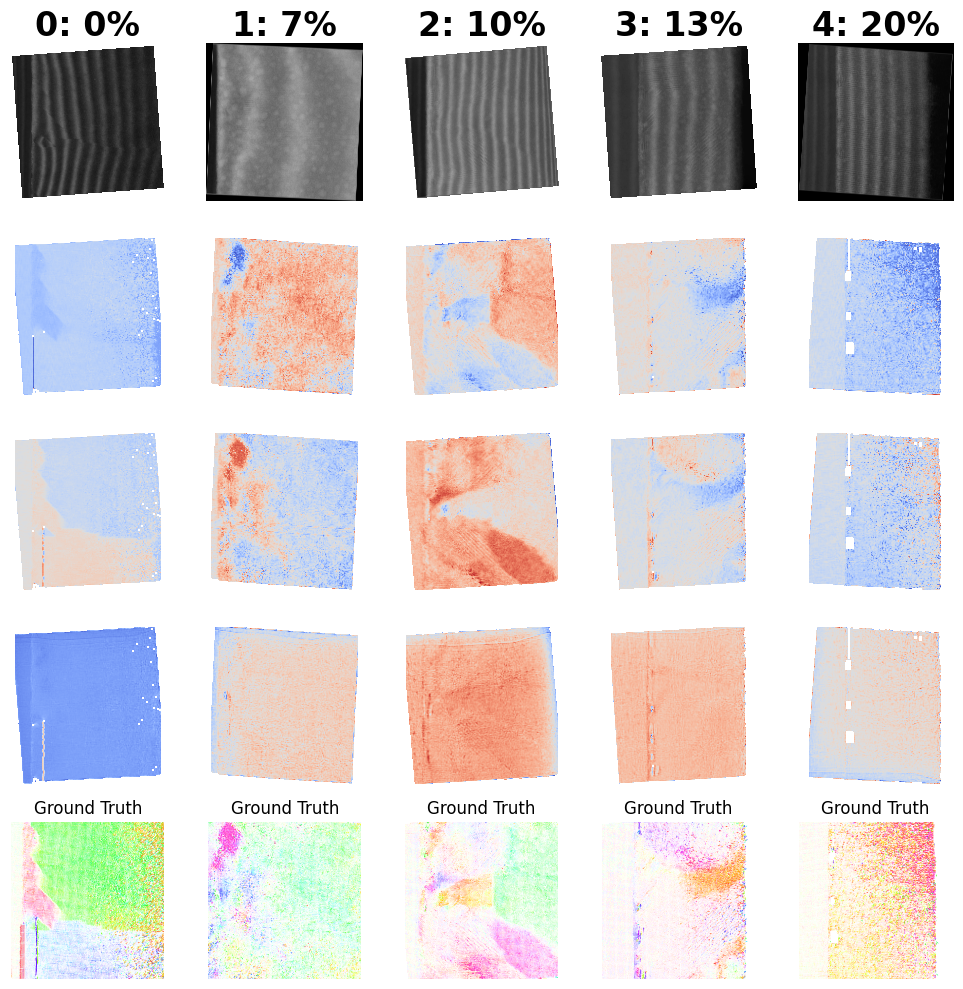

In [9]:
main = [350, 4000, 350, 4100]
fig, ax = plt.subplots(nrows=5, ncols=len(SBFOdata), figsize=(10, 10), dpi=100)
for i, k in enumerate(SBFOdata):
    #Image
    ax[0,i].imshow(k['Image'], origin='lower', cmap='gray')
    ax[0,i].set_title(str(k['Index'])+': '+str(k['Composition'])+'%', fontsize = 24, fontweight = "bold")
    ax[0,i].set_axis_off()
    #Px
    ax[1,i].imshow(k['ab_Px'], origin='lower', cmap='coolwarm')
    ax[1,i].set_axis_off()
    #Py
    ax[2,i].imshow(k['ab_Py'], origin='lower', cmap='coolwarm')
    ax[2,i].set_axis_off()

    # Vol (added row to display Vol)
    ax[3, i].imshow(k['Vol'], origin='lower', cmap='coolwarm')
    ax[3, i].set_axis_off()
    Y, X, U, V, cP = plot_polarization_vectors(k)
    ax[4, i].quiver(Y, X, U, V, color=cP, scale=0.1, angles='xy', scale_units='xy', width=0.002)
    ax[4, i].set_title('Ground Truth')
    ax[4, i].set_xlim(main[0], main[1])
    ax[4, i].set_ylim(main[2], main[3])
    ax[4, i].set_aspect('equal') 
    ax[4, i].axis("off")

plt.tight_layout()
plt.show()



In [84]:
chip_width =100
chip_height = 100
window_size = (chip_width, chip_height)
step_size = 45

imstack_grid, com_grid = custom_subimages(imgdata[1], step_size, window_size)

print(imstack_grid.shape)
print(com_grid.shape)

Number of subimages removed due to size mismatch: 368
Number of subimages removed due to NaNs: 0
(8281, 100, 100)
(8281, 2)


In [93]:
import tensorflow as tf

In [94]:
def img_embedding(image, preprocess_input, base_model, model_input_size=(32,32)):
    #x = tf.image.resize(image, size=model_input_size)
    if len(image.shape) == 2:  # If image is (32, 32), add channels
        image = tf.expand_dims(image, axis=-1)  # Now shape is (32, 32, 1)
        image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB (32, 32, 3)
    x = preprocess_input(image)
    x = base_model(np.expand_dims(x, axis=0))
    return x 

In [ ]:
patch_size = (chip_width, chip_width)
model_input_shape = patch_size + (3,)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
base_model = tf.keras.applications.vgg16.VGG16(input_shape=model_input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

chip_emb_dict={}
for i,v in enumerate(imstack_grid):
    chip_emb_dict[i] = img_embedding(v, preprocess_input, base_model, model_input_shape[:2]).numpy().flatten()

In [ ]:
chip_emb_dict

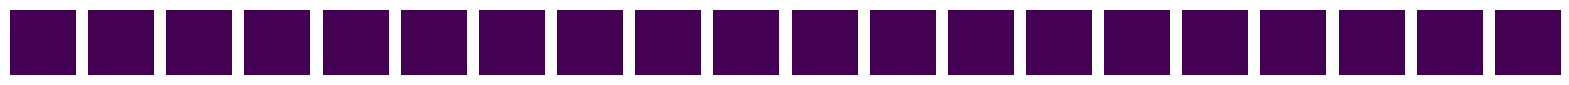

In [85]:
fig, ax = plt.subplots(ncols = 20, figsize = (20,20))
for i, image in enumerate(imstack_grid):
    ax[i].imshow(image)
    ax[i].set_axis_off()
    if i == 19:
        break

In [86]:
from sklearn.cluster import KMeans
patch_vectors = imstack_grid.reshape(imstack_grid.shape[0], -1)
n_clusters = 5
testing1= KMeans(n_clusters=n_clusters).fit(patch_vectors)

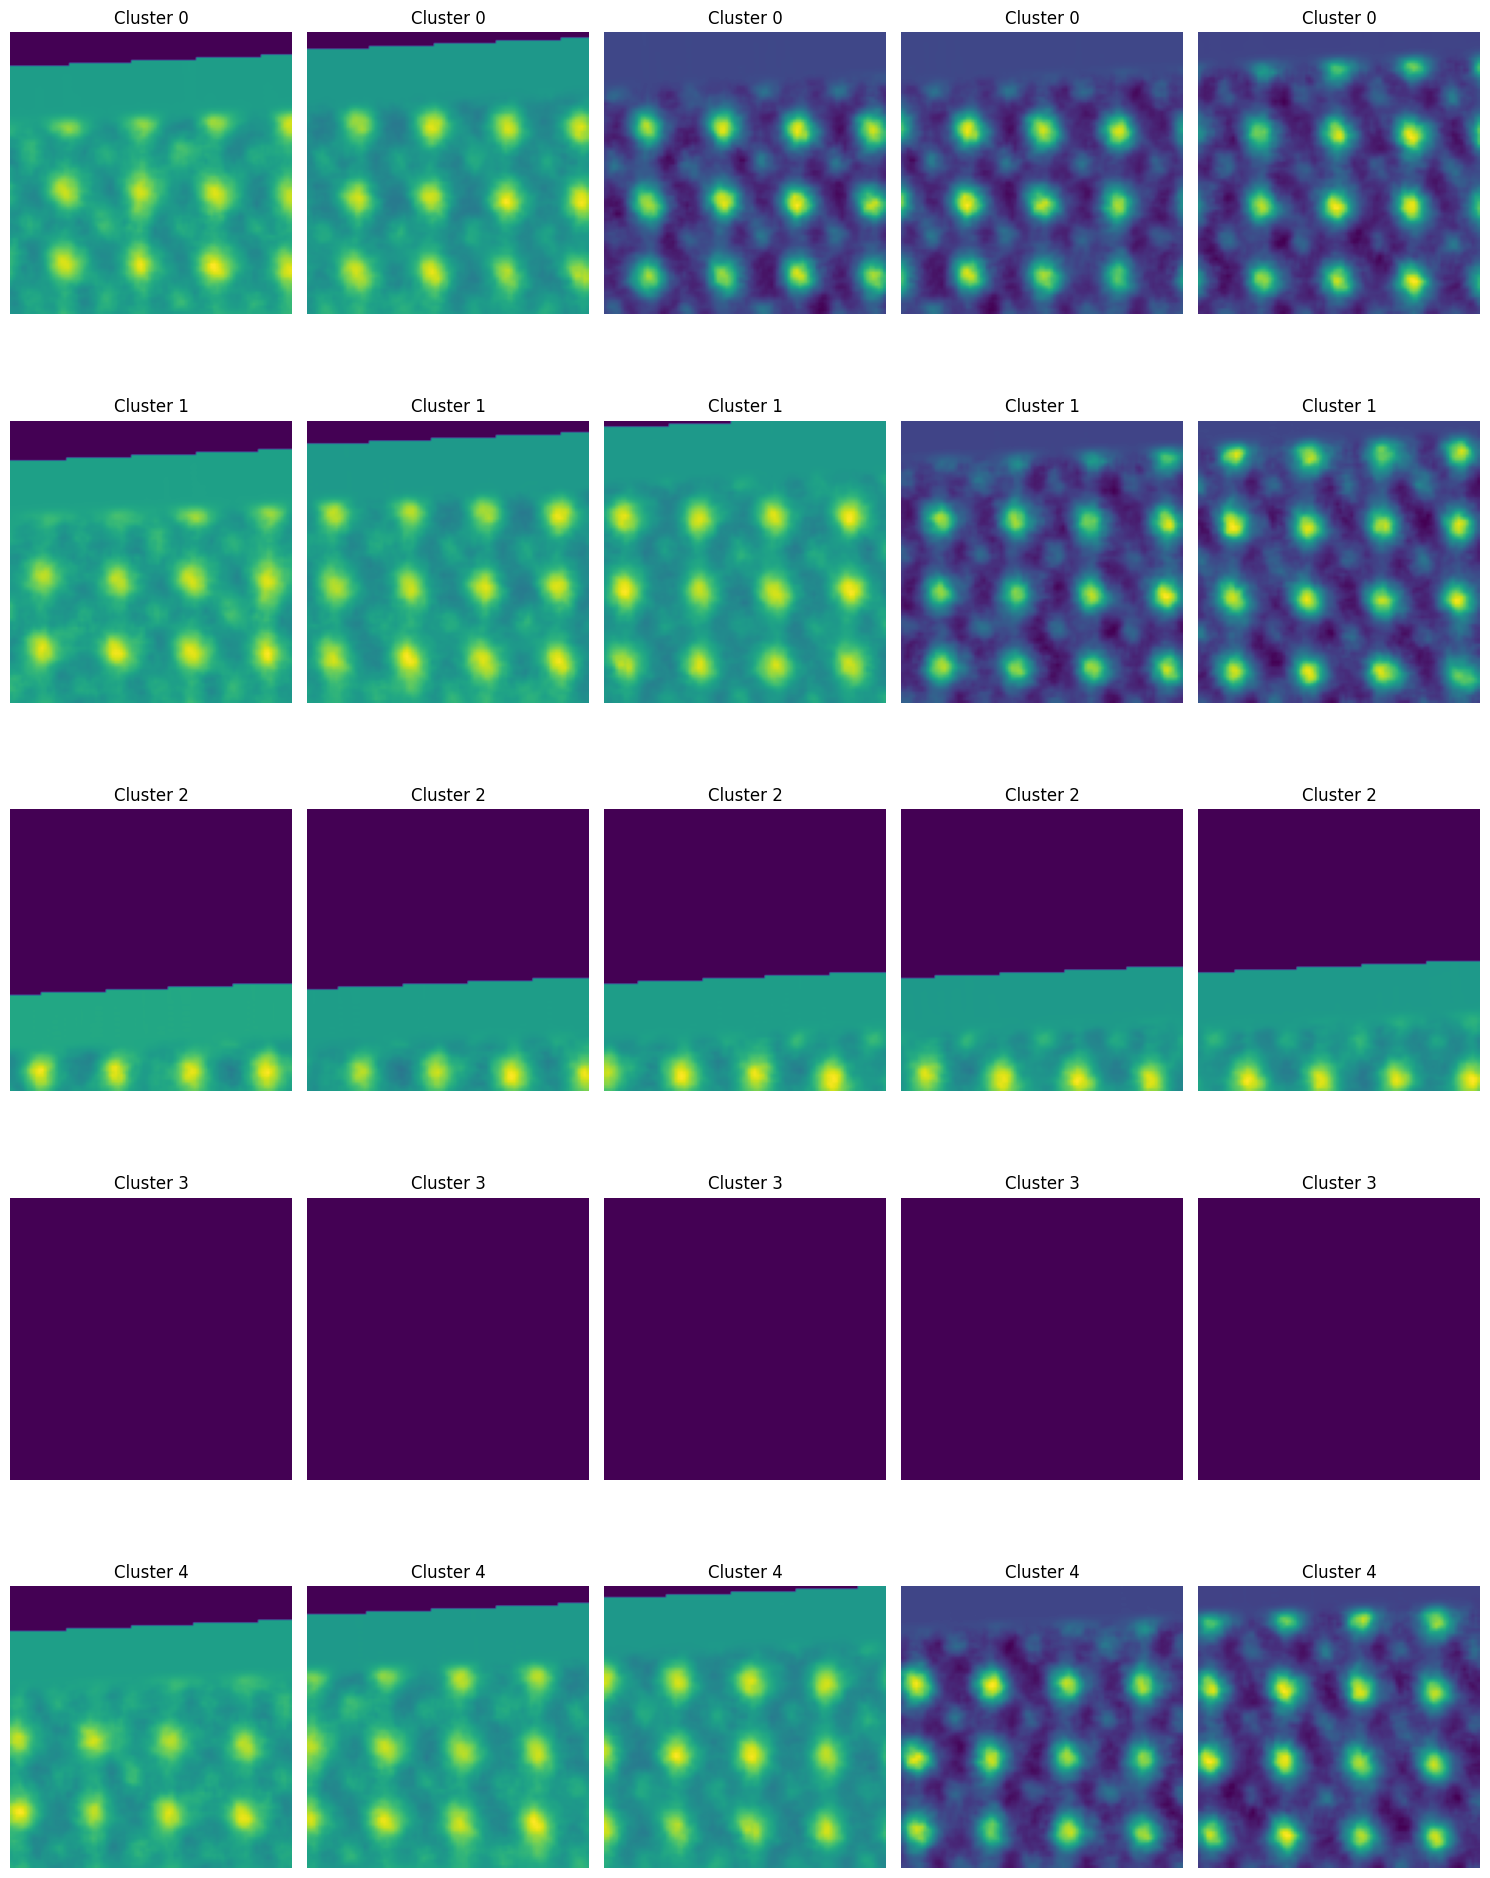

In [87]:
cluster_labels = testing1.labels_

# Visualize a few patches from each cluster
fig, axes = plt.subplots(n_clusters, 5, figsize=(15, 20))
for cluster in range(n_clusters):
    cluster_patches = imstack_grid[cluster_labels == cluster][:5]  # Select up to 5 patches from each cluster
    for i, patch in enumerate(cluster_patches):
        axes[cluster, i].imshow(patch)
        axes[cluster, i].axis('off')
        axes[cluster, i].set_title(f"Cluster {cluster}")
plt.tight_layout()
plt.show()


In [88]:
for cluster in range(n_clusters):
    print(len(imstack_grid[cluster_labels == cluster]))

2566
2359
127
603
2626


In [89]:
cluster_labels

array([3, 3, 3, ..., 3, 3, 3], dtype=int32)

In [90]:

cmap = plt.cm.get_cmap('Set1', len(np.unique(cluster_labels)))
cluster_colors = cmap(cluster_labels)

/var/folders/fq/mzw5cbdd00ngfgjzxd290glstylzhn/T/ipykernel_50629/3404567666.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', len(np.unique(cluster_labels)))


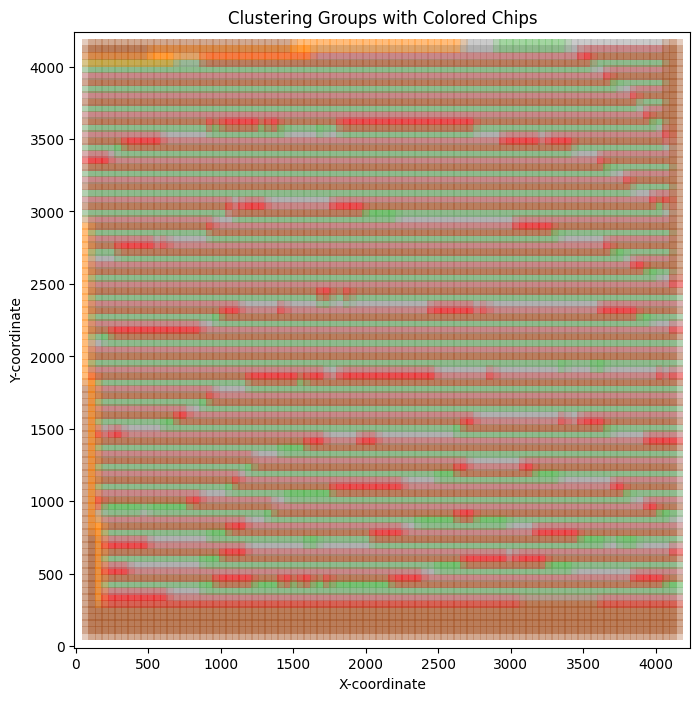

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))

# Loop through each chip and plot it as a rectangle
for i, (center_x, center_y) in enumerate(com_grid):
    # Calculate bottom-left corner of the rectangle
    bottom_left_x = center_x - chip_width / 2
    bottom_left_y = center_y - chip_height / 2
    
    # Create a rectangle
    rect = patches.Rectangle((bottom_left_x, bottom_left_y), 
                             chip_width, chip_height, 
                             linewidth=1, 
                             edgecolor='none', 
                             facecolor=cluster_colors[i], alpha = .3)
    ax.add_patch(rect)

# Set axis limits for better visualization
ax.set_xlim(com_grid[:, 0].min() - chip_width, com_grid[:, 0].max() + chip_width)
ax.set_ylim(com_grid[:, 1].min() - chip_height, com_grid[:, 1].max() + chip_height)

# Add labels
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_title("Clustering Groups with Colored Chips")

# Add a legend-like colorbar for clusters
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(np.unique(cluster_labels))-1))
sm.set_array([])
#plt.colorbar(sm, label="Cluster ID")

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
plt.show()